In [2]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [16]:
def crop_single_image(image_path, resize_shape=(800, 1000), margin=0):
    """
    Crops a single image at the largest white→black brightness drop.
    Returns: cropped_image, cut_row
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Unreadable file: {image_path}")

    # Resize for consistency
    img = cv2.resize(img, resize_shape)

    # Convert to grayscale & blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (7, 7), 0)

    # Compute brightness profile & gradient
    row_mean = np.mean(gray_blur, axis=1)
    row_norm = (row_mean - np.min(row_mean)) / (np.ptp(row_mean) + 1e-6)
    gradient = np.gradient(row_norm)

    # Find largest negative drop (white → black)
    drop_row = int(np.argmin(gradient))

    # Validate boundary
    if drop_row < 100 or drop_row >= img.shape[0]:
        raise ValueError(f"Invalid boundary (drop_row={drop_row}) in {image_path}")

    # Crop image above detected boundary
    cut_row = max(0, drop_row - margin)
    cropped = img[:cut_row, :]

    if cropped.size == 0:
        raise ValueError(f"Empty crop for {image_path}")

    return cropped, cut_row

In [11]:
# ------------------------------------------------------------
# 2️⃣ Process all images in a folder
# ------------------------------------------------------------
def crop_folder(input_folder, output_folder, resize_shape=(800, 1000), margin=0):
    """
    Applies brightness-drop cropping to all images in a folder.
    """
    os.makedirs(output_folder, exist_ok=True)
    image_files = [f for f in os.listdir(input_folder)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    for filename in tqdm(image_files, desc=f"Cropping images in {os.path.basename(input_folder)}"):
        path = os.path.join(input_folder, filename)
        try:
            cropped, cut_row = crop_single_image(path, resize_shape, margin)
            save_path = os.path.join(output_folder, filename)
            cv2.imwrite(save_path, cropped)
        except Exception as e:
            print(f"⚠️ Skipped {filename}: {e}")

    print(f"✅ Done. Cropped images saved in: {output_folder}")


In [12]:
# ------------------------------------------------------------
# 3️⃣ Plot the cutoff threshold for one image
# ------------------------------------------------------------
def plot_cutoff(image_path, resize_shape=(800, 1000)):
    """
    Plots the brightness profile and detected cutoff for a given image.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Unreadable file: {image_path}")

    img = cv2.resize(img, resize_shape)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (7, 7), 0)

    row_mean = np.mean(gray_blur, axis=1)
    row_norm = (row_mean - np.min(row_mean)) / (np.ptp(row_mean) + 1e-6)
    gradient = np.gradient(row_norm)
    drop_row = int(np.argmin(gradient))

    plt.figure(figsize=(10, 4))
    plt.plot(row_norm, label="Brightness", color='teal')
    plt.plot(gradient, label="Gradient", color='orange')
    plt.axvline(drop_row, color='red', linestyle='--', label=f"Cut Row {drop_row}")
    plt.title(f"Brightness Profile – {os.path.basename(image_path)}")
    plt.xlabel("Row index (top → bottom)")
    plt.ylabel("Normalized intensity")
    plt.legend()
    plt.show()

    print(f"Detected cut row: {drop_row}")


In [23]:
input_folder = r"E:\Jain Irrigation\data\D\train"
output_folder = r"E:\Jain Irrigation\data\D\train_cropped"

In [24]:
crop_folder(
    input_folder,
    output_folder,
)

Cropping images in train: 100%|██████████| 92/92 [00:06<00:00, 14.49it/s]

✅ Done. Cropped images saved in: E:\Jain Irrigation\data\D\train_cropped


Detected boundary row: 828


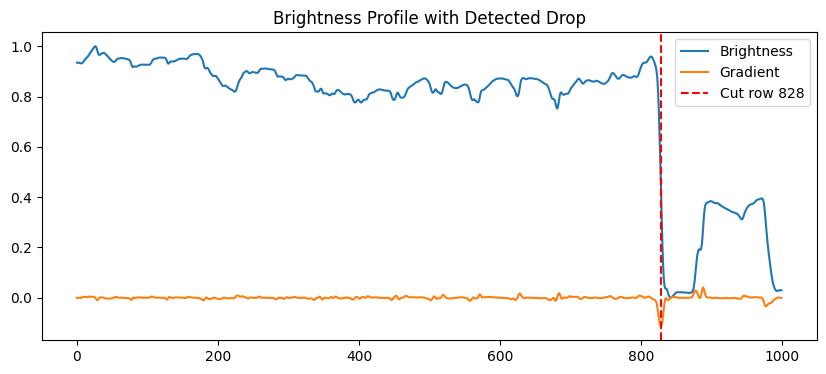

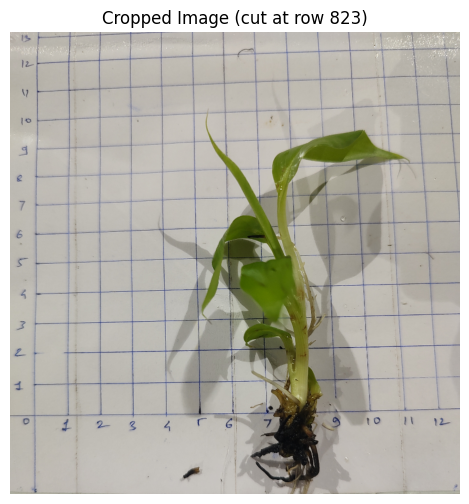

In [18]:
image_path = r"E:\Jain Irrigation\data\A\IMG_20250920_114321040.jpg"

resize_shape = (800, 1000)
sensitivity = -0.25  # tune: -0.15 (more sensitive) → -0.35 (stricter)

# --- Step 1: Load & preprocess ---
img = cv2.imread(image_path)
img = cv2.resize(img, resize_shape)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (7,7), 0)

# Brightness profile
row_mean = np.mean(gray_blur, axis=1)
row_norm = (row_mean - np.min(row_mean)) / (np.ptp(row_mean) + 1e-6)
gradient = np.gradient(row_norm)

# --- Find largest negative drop (white→black) ---
drop_row = np.argmin(gradient)        # index of steepest brightness fall
print(f"Detected boundary row: {drop_row}")

# --- Visualize ---
plt.figure(figsize=(10,4))
plt.plot(row_norm, label="Brightness")
plt.plot(gradient, label="Gradient")
plt.axvline(drop_row, color='r', linestyle='--', label=f"Cut row {drop_row}")
plt.legend(); plt.title("Brightness Profile with Detected Drop"); plt.show()

# --- Crop above that row (add small margin if you like) ---
margin = 5
cut_row = max(0, drop_row - margin)
cropped = img[:cut_row, :]

# Display result
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.title(f"Cropped Image (cut at row {cut_row})")
plt.axis('off')
plt.show()

In [1]:
image_path = r"E:\Jain Irrigation\data\D\train_cropped\IMG_20250922_115338356_HDR.jpg"
resize_shape = (800, 1000)
margin = 5

# --- Load & preprocess ---
img = cv2.imread(image_path)
img = cv2.resize(img, resize_shape)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (7,7), 0)

# --- Compute brightness & gradient ---
row_mean = np.mean(gray_blur, axis=1)
row_norm = (row_mean - np.min(row_mean)) / (np.ptp(row_mean) + 1e-6)
gradient = np.gradient(row_norm)

# --- Find steepest brightness drop ---
drop_row = int(np.argmin(gradient))
cut_row = max(0, drop_row - margin)

print(f"Detected steepest drop at row {drop_row}/{img.shape[0]}")

# --- Plot diagnostic profile ---
plt.figure(figsize=(10,4))
plt.plot(row_norm, label="Brightness (normalized)")
plt.plot(gradient, label="Gradient")
plt.axvline(drop_row, color='r', linestyle='--', label=f"Cut row {drop_row}")
plt.legend()
plt.title("Brightness & Gradient Profile – Crop Diagnosis")
plt.xlabel("Row index (top to bottom)")
plt.ylabel("Normalized intensity")
plt.show()

# --- Show where that line sits on the image ---
img_display = img.copy()
cv2.line(img, (0, cut_row), (img_display.shape[1], cut_row), (0,0,255), 2)
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Cut Row = {cut_row}")
plt.axis('off')
plt.show()


NameError: name 'cv2' is not defined

Detected bottom boundary at row 864/1000


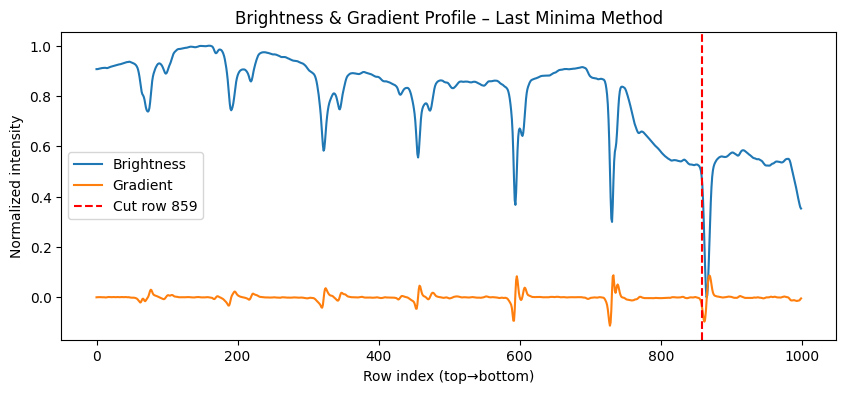

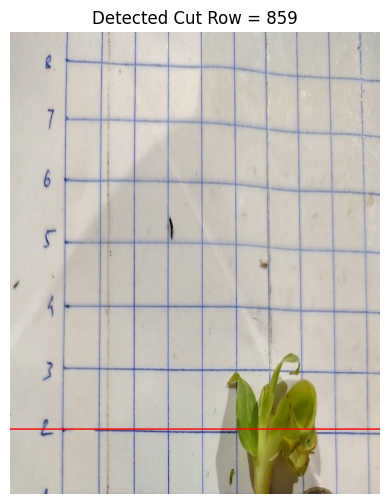

In [23]:
image_path = r"E:\Jain Irrigation\data\D\train_cropped\IMG_20250922_115338356_HDR.jpg"
resize_shape = (800, 1000)
drop_threshold = -0.05    # how strong the drop must be
margin = 5

img = cv2.imread(image_path)
img = cv2.resize(img, resize_shape)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (7,7), 0)

row_mean = np.mean(gray_blur, axis=1)
row_norm = (row_mean - np.min(row_mean)) / (np.ptp(row_mean) + 1e-6)
gradient = np.gradient(row_norm)

# --- find all rows where gradient drops below threshold ---
candidates = np.where(gradient < drop_threshold)[0]

if len(candidates) == 0:
    print("⚠️  No clear minima found.")
    cut_row = None
else:
    drop_row = int(candidates[-1])        # last significant drop
    cut_row = max(0, drop_row - margin)
    print(f"Detected bottom boundary at row {drop_row}/{img.shape[0]}")

# --- plot brightness + gradient ---
plt.figure(figsize=(10,4))
plt.plot(row_norm, label="Brightness")
plt.plot(gradient, label="Gradient")
if cut_row:
    plt.axvline(cut_row, color='r', linestyle='--', label=f"Cut row {cut_row}")
plt.legend(); plt.title("Brightness & Gradient Profile – Last Minima Method")
plt.xlabel("Row index (top→bottom)"); plt.ylabel("Normalized intensity")
plt.show()

# --- show detected boundary on image ---
if cut_row:
    img_disp = img.copy()
    cv2.line(img_disp, (0, cut_row), (img_disp.shape[1], cut_row), (0,0,255), 2)
    plt.figure(figsize=(6,6))
    plt.imshow(cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB))
    plt.title(f"Detected Cut Row = {cut_row}")
    plt.axis('off'); plt.show()